In [1]:
import pandas as pd
import numpy as np
import requests
import json
import os
import plistlib

pd.set_option('max_colwidth', 150)

# Perform query

In [2]:
query = """[out:json];
(
  node["name"]["tourism"="museum"];
  node["name"]["tourism"="artwork"];
  node["name"]["amenity"="fountain"];
  node["name"]["historic"];
  node["name"]["amenity"="theatre"];
  way["name"]["tourism"="museum"];
  way["name"]["tourism"="artwork"];
  way["name"]["amenity"="fountain"];
  way["name"]["historic"];
  way["name"]["amenity"="theatre"];
);
out center;
>;
out qt;
"""

In [3]:
def overpass_query(query=None, overwrite=False):
    if os.path.exists("db.pickle") and not overwrite:
        return pd.read_pickle("db.pickle")
    
    if not query:
        print("Database not found on disk. You must provide a valid query.")
        return
    
    try:
        r = requests.get(url="http://127.0.0.1/api/interpreter", data=query)
        json_result = json.loads(r.content)
        df = pd.DataFrame(json_result["elements"])
        df.to_pickle("db.pickle")
        return df
    except Exception as e:
        print(e)

In [4]:
df = overpass_query(query)

# Database preparation: Nodes and Ways

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219441 entries, 0 to 219440
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   type    219441 non-null  object 
 1   id      219441 non-null  int64  
 2   lat     203706 non-null  float64
 3   lon     203706 non-null  float64
 4   tags    39911 non-null   object 
 5   center  15735 non-null   object 
 6   nodes   15735 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 11.7+ MB


## Get only records with tags and name

In [6]:
df = df[df.tags.notnull()]
df = df[df.apply(lambda x: "name" in x.tags, axis=1)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37896 entries, 0 to 219155
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   type    37896 non-null  object 
 1   id      37896 non-null  int64  
 2   lat     22161 non-null  float64
 3   lon     22161 non-null  float64
 4   tags    37896 non-null  object 
 5   center  15735 non-null  object 
 6   nodes   15735 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 2.3+ MB


## Create latitude and longitude from center for Ways

In [7]:
df_nodes = df.query("type == 'node'")
df_ways = df.query("type == 'way'")

df_ways = df_ways.assign(latitude=df_ways["center"].apply(lambda x: x["lat"]), longitude=df_ways["center"].apply(lambda x: x["lon"]))

In [8]:
df_ways.head()

,type,id,lat,lon,tags,center,nodes,latitude,longitude
21919,way,4497863,NaN,NaN,"{'addr:city': 'Milano', 'addr:country': 'IT', 'addr:housenumber': '1', 'addr:street': 'Via Giovanni Rota', 'amenity': 'theatre', 'building': 'publ...","{'lat': 45.4667635, 'lon': 9.1539554}","[27585621, 1532988874, 1532988867, 27585622, 27585619, 27585620, 27585621]",45.466763,9.153955
21920,way,4519679,NaN,NaN,"{'historic': 'archaeological_site', 'historic:civilization': 'western_roman', 'historic:period': 'dominate', 'name': 'Villa Imperiale', 'ruins': '...","{'lat': 45.46513, 'lon': 9.1805469}","[27732704, 2886739086, 2886739198, 304776292, 3333717879, 27732700, 27732702, 304776291, 27732703, 574389898, 1929235329, 1929235326, 27732704]",45.465130,9.180547
21921,way,4998830,NaN,NaN,"{'addr:city': 'Milano', 'addr:country': 'IT', 'addr:housenumber': '1', 'addr:street': 'Largo Antonio Greppi', 'amenity': 'theatre', 'building': 'p...","{'lat': 45.4725633, 'lon': 9.1823066}","[33198078, 33198069, 33198070, 33198071, 33198072, 395252763, 1692325433, 33198073, 4061689060, 33198074, 33198076, 3789138194, 1692325434, 445757...",45.472563,9.182307
21922,way,8035487,NaN,NaN,"{'building': 'yes', 'building:part': 'no', 'castle_type': 'fortress', 'charge': '14 EUR', 'email': 'sspsae-rm.castelsantangelo@beniculturali.it', ...","{'lat': 41.9030762, 'lon': 12.4663312}","[60071946, 5730657087, 2686698641, 2686698614, 2686698541, 2686698487, 2686698470, 2686698459, 2686698454, 60071948, 2686698432, 2686698430, 26866...",41.903076,12.466331
21923,way,11116333,NaN,NaN,"{'building': 'yes', 'historic': 'city_gate', 'name': 'Porta Pia', 'tourism': 'attraction', 'wikidata': 'Q3908761', 'wikipedia': 'it:Porta Pia (Anc...","{'lat': 43.615323, 'lon': 13.5049486}","[99064812, 99064884, 663913930, 99064891, 99064901, 663913929, 99064812]",43.615323,13.504949


## Concatenate nodes and ways

In [9]:
df_nodes = df_nodes.rename(columns={"lat": "latitude", "lon": "longitude"})
df_nodes = df_nodes[["id", "latitude", "longitude", "tags"]]
df_ways = df_ways[["id", "latitude", "longitude", "tags"]]

df = pd.concat([df_nodes, df_ways])
df.head()

,id,latitude,longitude,tags
0,21027591,42.662755,11.636329,"{'historic': 'archaeological_site', 'name': 'Via cava del Cavone'}"
1,26864200,44.543438,9.652994,"{'historic': 'memorial', 'name': 'Croce del Pelpi'}"
2,33148157,45.042277,11.750620,"{'historic': 'monument', 'name': 'Pavajon'}"
3,62512260,45.972641,9.453071,"{'historic': 'yes', 'is_in': 'Lecco, Lombardia, Italy', 'name': 'Introbio', 'place': 'village', 'population': '1605'}"
4,64776777,45.936835,11.095180,"{'historic': 'monument', 'name': 'Kaiserschuetzen 1917', 'tourism': 'artwork', 'wheelchair': 'yes'}"


# Database Cleaning

## Name and wikiUrl definition

In [10]:
def wikipedia_url(tags):
    if "wikipedia" in tags:
        wiki = tags["wikipedia"]
        if "https" not in wiki:
            base_url = "https://%s.wikipedia.org/wiki/%s"
            
            if len(wiki.split(":")) > 1:
                lang, name = wiki.split(":")
                name = "_".join(name.split(" "))
            else:
                lang = "it"
                name = "_".join(wiki.split(" "))
            return "https://%s.wikipedia.org/wiki/%s" % (lang, name)
        else:
            return wiki
        
def wiki_pageid(tags):
    if "wikipedia" in tags:
        wiki = tags["wikipedia"]
        
        if "https" in wiki:
            pageid = wiki.split("/")[-1]
            extension = pageid.split(".")
            
            if len(extension) > 1:
                return None
            pageid = " ".join(pageid.split("_"))
            lang = wiki.split("/")[2].split(".")[0]
            return f"{lang}:pageid"
        else:
            if len(wiki.split(":")) == 2:
                return wiki
            

df["name"] = df.apply(lambda x: x.tags["name"], axis=1)
df["wikiUrl"] = df.apply(lambda x: wiki_pageid(x.tags), axis=1)
df.head()

,id,latitude,longitude,tags,name,wikiUrl
0,21027591,42.662755,11.636329,"{'historic': 'archaeological_site', 'name': 'Via cava del Cavone'}",Via cava del Cavone,None
1,26864200,44.543438,9.652994,"{'historic': 'memorial', 'name': 'Croce del Pelpi'}",Croce del Pelpi,None
2,33148157,45.042277,11.750620,"{'historic': 'monument', 'name': 'Pavajon'}",Pavajon,None
3,62512260,45.972641,9.453071,"{'historic': 'yes', 'is_in': 'Lecco, Lombardia, Italy', 'name': 'Introbio', 'place': 'village', 'population': '1605'}",Introbio,None
4,64776777,45.936835,11.095180,"{'historic': 'monument', 'name': 'Kaiserschuetzen 1917', 'tourism': 'artwork', 'wheelchair': 'yes'}",Kaiserschuetzen 1917,None


Some elements have only numeric names. Get rid of them.

In [11]:
numeric_names = df["name"].apply(lambda x: x.isdigit())
df[numeric_names].sample(5)

,id,latitude,longitude,tags,name,wikiUrl
512,388405808,44.457279,9.970312,"{'historic': 'boundary_stone', 'name': '1828'}",1828,None
12207,3978703204,46.072092,11.468678,"{'alt_name': 'Sei', 'artwork_type': 'statue', 'cover': 'roof', 'denomination': 'catholic', 'material': 'wood', 'name': '06', 'religion': 'christia...",06,None
21778,6646396936,45.661288,11.182490,"{'denomination': 'catholic', 'historic': 'wayside_shrine', 'name': '11', 'religion': 'christian', 'worship': 'station_of_the cross'}",11,None
5295,2012882375,44.468460,9.845943,"{'historic': 'boundary_stone', 'name': '1828'}",1828,None
21780,6646396938,45.660825,11.183029,"{'denomination': 'catholic', 'historic': 'wayside_shrine', 'name': '9', 'religion': 'christian'}",9,None


In [12]:
# Keep only not numeric names
df = df[~numeric_names]

## Tags

In [13]:
# Load Monument Tags
with open("../Monuments/Support Files/MonumentCategories.plist", "rb") as f:
    monumentTags = pd.DataFrame.from_dict(plistlib.load(f)["categories"], orient="index")
monumentTags

,priority,description,category
archaeological_site,1000,"{'it': 'Sito Archeologico', 'en': 'Archaeological Site'}","{'it': 'Siti Archeologici', 'en': 'Archaeological Sites'}"
artwork,250,"{'it': 'Opera d'arte', 'en': 'Artwork'}","{'it': 'Opere d'arte', 'en': 'Artworks'}"
cemetery,1000,"{'it': 'Cimitero - Tomba', 'en': 'Cimitery - Tomb'}","{'it': 'Cimiteri - Tombe', 'en': 'Cimiteries - Tombs'}"
fountain,1000,"{'it': 'Fontana', 'en': 'Fountain'}","{'it': 'Fontane', 'en': 'Fountains'}"
memorial,250,"{'it': 'Memoriale', 'en': 'Memorial'}","{'it': 'Memoriali', 'en': 'Memorials'}"
monument,1000,"{'it': 'Monumento', 'en': 'Monument'}","{'it': 'Monumenti', 'en': 'Monuments'}"
museum,1000,"{'it': 'Museo', 'en': 'Museum'}","{'it': 'Musei', 'en': 'Museums'}"
palace,750,"{'it': 'Palazzo Storico', 'en': 'Historical Palace'}","{'it': 'Palazzi Storici', 'en': 'Historical Palaces'}"
place_of_worship,1000,"{'it': 'Luogo di Culto', 'en': 'Place of Worship'}","{'it': 'Luoghi di Culto', 'en': 'Places of Worship'}"
ruins,750,"{'it': 'Rovina', 'en': 'Ruins'}","{'it': 'Rovine', 'en': 'Ruins'}"


Let's find whose entires have categories matching those required

In [14]:
def find_most_significant_category(tags):
    tag_values = list(tags.values())
    for i, value in enumerate(tag_values):
        if value == "tomb" or value == "tombstone":
            tag_values[i] = "cemetery"
            
    categories = list(set(tag_values) & set(monumentTags.index))
    return categories if len(categories) > 0 else None

significant_tags = df["tags"].apply(find_most_significant_category)

In [15]:
insignificant_tags = significant_tags.isna()
print(f"Found {insignificant_tags.sum()} entries without significant categories.")

Found 12500 entries without significant categories.


In [16]:
significant_tags = significant_tags.dropna()
print("Numer of significant tags before selection: %d" % len(significant_tags))

Numer of significant tags before selection: 25340


Let's find whose entries have more than one desired category

### Not unique categories

In [17]:
not_unique_categories = significant_tags.loc[significant_tags[significant_tags.apply(lambda x: len(x) > 1)].index]
print(f"{len(not_unique_categories)} entires have more than one desired categoriy.")

1463 entires have more than one desired categoriy.


In [18]:
df.loc[not_unique_categories.index].assign(categories=not_unique_categories)[["name", "categories"]].head(5)

,name,categories
4,Kaiserschuetzen 1917,"[artwork, monument]"
97,Santa Maria in Portuno,"[place_of_worship, archaeological_site]"
115,Redentore,"[artwork, memorial, statue]"
124,Chiesa di San Gervasio in Bulgaria,"[place_of_worship, archaeological_site]"
221,Statua di Walther von der Vogelweide - Walther-von-der-Vogelweide-Denkmal,"[artwork, statue]"


In [19]:
multiple_categories = []
for l in not_unique_categories.values:
    if sorted(l) not in multiple_categories:
        multiple_categories.append(sorted(l))
print(f"Found {len(multiple_categories)} different groups of multiple categories")

Found 51 different groups of multiple categories


In [20]:
multiple_categories

[['artwork', 'monument'],
 ['archaeological_site', 'place_of_worship'],
 ['artwork', 'memorial', 'statue'],
 ['artwork', 'statue'],
 ['monument', 'place_of_worship'],
 ['memorial', 'statue'],
 ['fountain', 'ruins'],
 ['artwork', 'fountain'],
 ['fountain', 'memorial'],
 ['place_of_worship', 'ruins'],
 ['archaeological_site', 'museum'],
 ['artwork', 'memorial'],
 ['fountain', 'monument'],
 ['artwork', 'monument', 'statue'],
 ['artwork', 'cemetery', 'statue'],
 ['artwork', 'place_of_worship'],
 ['archaeological_site', 'ruins'],
 ['monument', 'museum'],
 ['monument', 'statue'],
 ['artwork', 'place_of_worship', 'statue'],
 ['artwork', 'fountain', 'monument'],
 ['museum', 'ruins'],
 ['memorial', 'monument'],
 ['artwork', 'fountain', 'statue'],
 ['archaeological_site', 'theatre'],
 ['archaeological_site', 'villa'],
 ['archaeological_site', 'cemetery'],
 ['ruins', 'villa'],
 ['artwork', 'cemetery'],
 ['archaeological_site', 'artwork'],
 ['memorial', 'place_of_worship', 'statue'],
 ['cemetery',

### Select one category based on priority
If multiple categories occur, choose the one with highest priority

In [21]:
def choose_category(categories):
    return monumentTags.loc[categories].priority.idxmax()

In [22]:
# Filter category based on priority
significant_tags = significant_tags.apply(lambda x: x[0])
filtered_categories = not_unique_categories.apply(choose_category)
significant_tags.loc[filtered_categories.index] = filtered_categories

# Dump cleaned Dataframe
Create a new column _category_

In [23]:
clean_df = df.assign(category=significant_tags).loc[significant_tags.index]
clean_df = clean_df.reset_index(drop=True)
clean_df.sample(50)

,id,latitude,longitude,tags,name,wikiUrl,category
22711,380545010,39.841759,18.235988,"{'building': 'collapsed', 'historic': 'ruins', 'name': 'Masseria Don Cesare'}",Masseria Don Cesare,None,ruins
6439,2843286210,37.099970,13.931765,"{'historic': 'archaeological_site', 'name': 'Phintias', 'wikidata': 'Q3745777', 'wikipedia': 'it:Finziade'}",Phintias,it:Finziade,archaeological_site
9912,4232055220,41.000009,8.234984,"{'historic': 'ruins', 'name': 'Castellaccio'}",Castellaccio,None,ruins
13341,5329181217,44.363640,7.863100,"{'cemetery': 'grave', 'location': 'Cappella di San Bernardo', 'name': 'Tomba di Vittorio Emanuele III', 'religion': 'christian', 'start_date': '20...",Tomba di Vittorio Emanuele III,None,artwork
831,648869919,40.132585,9.266058,"{'historic': 'archaeological_site', 'historic:civilization': 'nuragic', 'megalith_type': 'nuraghe', 'name': 'Nuraghe Dronnoro', 'ruins': 'yes', 's...",Nuraghe Dronnoro,None,archaeological_site
46,252187876,45.656912,13.772568,"{'historic': 'monument', 'name': 'Monumento all'Imperatrice Elisabetta d'Austria'}",Monumento all'Imperatrice Elisabetta d'Austria,None,monument
877,665482029,41.689257,12.789373,"{'amenity': 'theatre', 'name': 'Teatro Ugo Tognazzi'}",Teatro Ugo Tognazzi,None,theatre
25044,662075333,41.898285,12.467742,"{'artist_name': 'Mario Rutelli', 'historic': 'monument', 'name': 'Monumento a Nicola Spedalieri'}",Monumento a Nicola Spedalieri,None,monument
20655,255930419,45.713078,11.356196,"{'addr:city': 'Schio', 'addr:housenumber': '44', 'addr:postcode': '36015', 'addr:street': 'Via Fratelli Pasini', 'building': 'yes', 'historic': 'y...",Palazzo Fogazzaro,it:Palazzo Fogazzaro,museum
17162,60224199,41.357380,13.429266,"{'historic': 'archaeological_site', 'name': 'Terme Romane', 'wikipedia': 'it:Terme romane (Fondi)'}",Terme Romane,it:Terme romane (Fondi),archaeological_site


Reset index

In [24]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25340 entries, 0 to 25339
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         25340 non-null  int64  
 1   latitude   25340 non-null  float64
 2   longitude  25340 non-null  float64
 3   tags       25340 non-null  object 
 4   name       25340 non-null  object 
 5   wikiUrl    3240 non-null   object 
 6   category   25340 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 1.4+ MB


In [25]:
def to_dict_dropna(data):
    return dict((k, v.dropna().to_dict()) for k, v in pd.compat.iteritems(data))

def dataframe_to_plist(df):
    with open("../Monuments/Support Files/Monuments.plist", "wb") as fp:
        df.index = df.index.astype(str)
        dictionary = [{k:v for k,v in m.items() if pd.notnull(v)} for m in df.to_dict(orient='rows')]
        plistlib.dump({"monuments": dictionary}, fp)

dataframe_to_plist(clean_df)

# Statistics

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

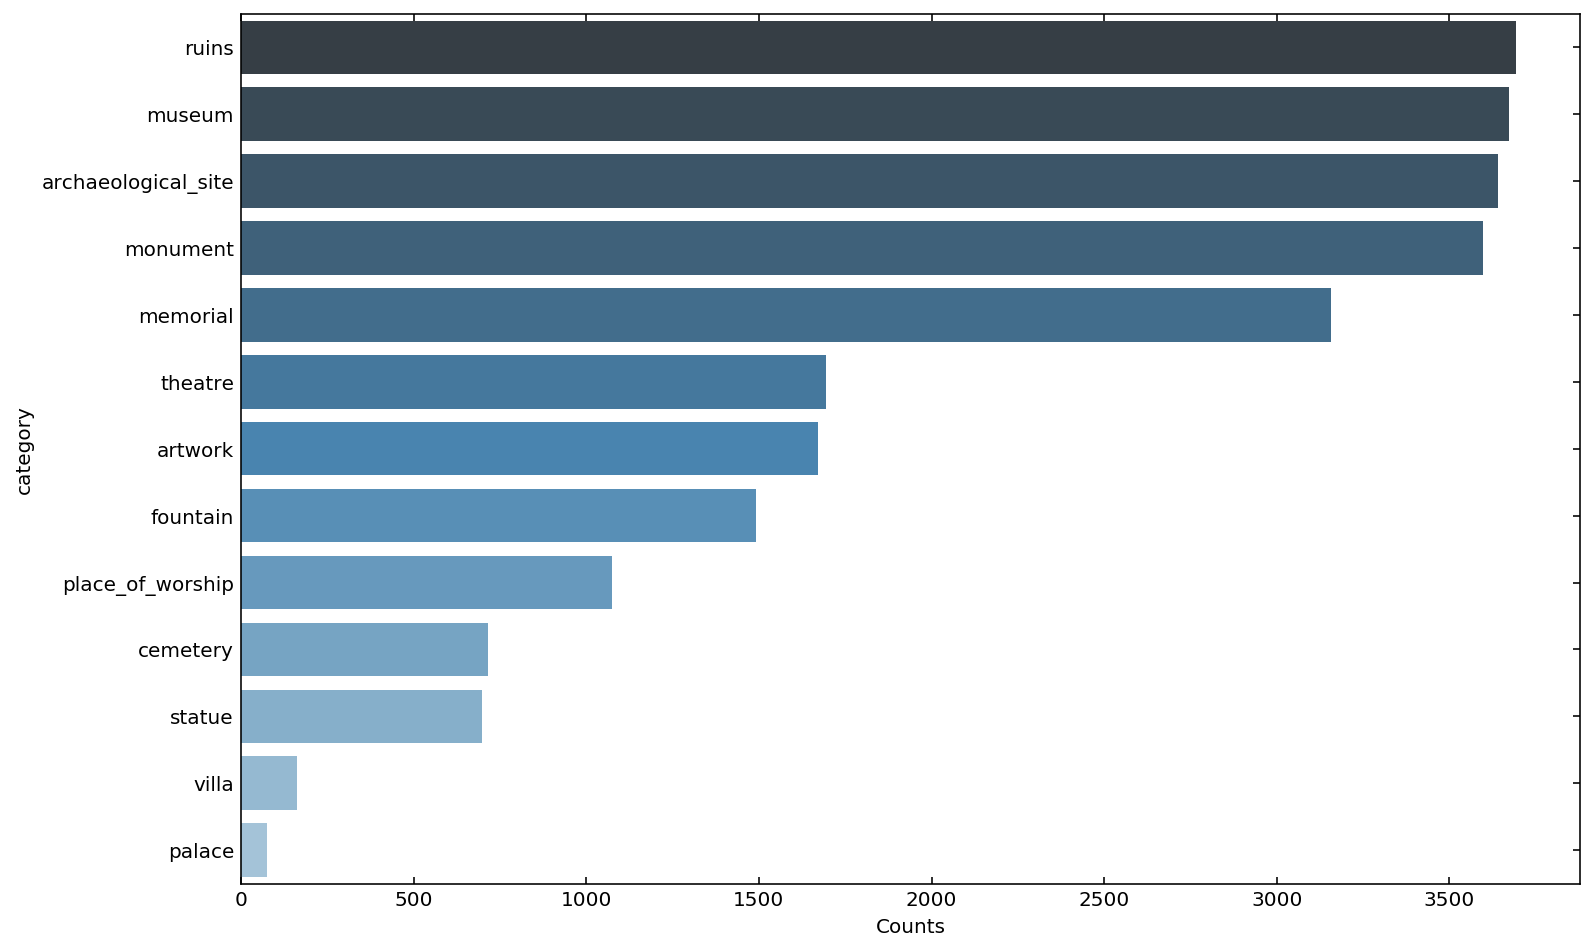

In [27]:
counts = clean_df.groupby("category").count().sort_values("id", ascending=False)["id"]
_, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x=counts, y=counts.index, palette=sns.color_palette("Blues_d", n_colors=len(counts.index)))
plt.xlabel("Counts")
plt.show()

In [28]:
clean_df[clean_df.category == "ruins"].sample(10)

,id,latitude,longitude,tags,name,wikiUrl,category
20366,242874551,44.894676,6.784628,"{'building': 'yes', 'historic': 'ruins', 'name': 'Caserma Carabinieri', 'source': 'Bing'}",Caserma Carabinieri,None,ruins
20804,262574306,42.079678,13.412953,"{'historic': 'ruins', 'name': 'Teatro'}",Teatro,None,ruins
20615,254502081,41.893900,12.554099,"{'historic': 'ruins', 'name': 'columbario'}",columbario,None,ruins
12465,5084608411,42.954868,12.882516,"{'historic': 'ruins', 'name': 'chiesa di San Sisto'}",chiesa di San Sisto,None,ruins
24561,572859326,45.657135,10.096185,"{'building': 'ruins', 'ele': '495', 'historic': 'ruins', 'name': 'Stalla Bruciata'}",Stalla Bruciata,None,ruins
4573,2288005015,45.470317,8.018033,"{'historic': 'ruins', 'name': 'Oratorio San Rocco'}",Oratorio San Rocco,None,ruins
17085,58606785,37.676107,12.567728,"{'building': 'yes', 'historic': 'ruins', 'name': 'Baglio Riolo'}",Baglio Riolo,None,ruins
18858,168421516,44.357190,10.432976,"{'historic': 'ruins', 'name': 'Rocca del Meloncio', 'source': 'Regione Emilia Romagna'}",Rocca del Meloncio,None,ruins
14706,5839613277,40.944328,15.783834,"{'historic': 'ruins', 'historic:civilization': 'ancient_roman', 'inscription': 'Cava dei pini', 'name': 'Cava'}",Cava,None,ruins
8487,3644120407,40.639385,17.945244,"{'historic': 'ruins', 'name': 'Capitello originale della Colonna Romana'}",Capitello originale della Colonna Romana,None,ruins


In [29]:
clean_df[clean_df["name"].str.contains("pompei", False)]

,id,latitude,longitude,tags,name,wikiUrl,category
7393,3174625766,41.214890,14.695782,"{'historic': 'monument', 'name': 'Effige della Madonna di Pompei'}",Effige della Madonna di Pompei,None,monument
16653,26707240,40.750919,14.486876,"{'area': 'yes', 'heritage': '1', 'heritage:operator': 'whc', 'historic': 'archaeological_site', 'historic:civilization': 'ancient_roman', 'importa...",Scavi archeologici di Pompei,it:Scavi archeologici di Pompei,archaeological_site
22473,369518385,45.595218,11.815971,"{'amenity': 'place_of_worship', 'building': 'chapel', 'denomination': 'catholic', 'historic': 'wayside_shrine', 'name': 'Beata Vergine di Pompei',...",Beata Vergine di Pompei,None,place_of_worship
22894,395802069,40.749328,14.484842,"{'historic': 'archaeological_site', 'name': 'Foro di Pompei', 'name:cs': 'pompejské forum', 'name:ko': '폼페이 포럼(포로 디 폼페이)', 'website': 'http://www....",Foro di Pompei,it:Foro di Pompei,archaeological_site


['http:', '', 'www.sardegnaabbandonata.it', 'villa-eleonora-ex-orfanotrofio']

In [30]:
clean_df[clean_df.name.str.contains("san galgano", case=False)]

,id,latitude,longitude,tags,name,wikiUrl,category
17993,124425420,43.149431,11.15535,"{'amenity': 'place_of_worship', 'building': 'yes', 'denomination': 'catholic', 'historic': 'ruins', 'name': 'Abbazia di San Galgano', 'religion': ...",Abbazia di San Galgano,it:Abbazia di San Galgano,place_of_worship
